In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statannot import add_stat_annotation

from utils import quick_load_liuzhong_health_check_data
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"

In [4]:
dir_path = "/cluster/home/bqhu_jh/projects/healthman"
output_dir = f"{dir_path}/analysis/"


df_table1plus_final_allmonths = pd.read_parquet(f"{output_dir}/tableOnePlusData-final_allmonths.parquet")
df_table1plus_final_allmonths

variable,birthday,year,month,day,gender,sample_id,v000760,v000761,v002266,v000763,...,v9464,v0015,v0016,v0027,v0026,v0032,age,year-month,age_groups,period
0,1935-08-25,2021,12,24,male,Da4TKCKNjTfO2CE73cGmYsytDz5zY9ZxX1C5OdZIUwx3vQ==,157.2,63.8,NaN,84.0,...,NaN,23.10,9.3,13.80,NaN,129.0,86,2021-12,>60,Control-2022
1,1935-09-27,2023,2,14,female,3LMkuxkqQtefLsMjWJ+T/cytDz5zZdZxX1C5ONZKUwh0vA==,152.0,52.5,NaN,71.0,...,NaN,7.60,2.8,4.80,4.0,84.0,88,2023-02,>60,Test-2023
2,1935-12-01,2021,6,8,male,5KGUOjagf2QfVhHEPAiW+cytDz5zZ9ZxX1C4M9RMUg53vA==,156.9,67.5,NaN,64.0,...,NaN,7.80,4.1,3.70,11.7,93.0,86,2021-06,>60,Control-2021
3,1936-04-03,2022,10,7,female,V/Lh31LCtw8A+AOXAwk4aMytDz5zZdZxX1O5NdROUwhyvQ==,146.9,54.1,NaN,94.0,...,3.58,7.90,3.1,4.80,NaN,65.0,86,2022-10,>60,None
4,1936-10-30,2021,2,5,female,CqpgapqSPchK77fFqauqSsytDz5zY9ZxX1O4MddNUgdy1g==,150.0,56.8,NaN,73.0,...,NaN,8.70,3.0,5.70,NaN,71.0,85,2021-02,>60,Control-2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235676,2001-07-13,2023,6,28,female,cs57W5NzI8055fwwuSj45MytDj97Y9V4XFS5NtVOUg50vQ==,167.0,55.5,NaN,74.0,...,3.93,19.30,6.4,12.90,3.8,58.0,22,2023-06,<30,Test-2023
235677,2001-07-31,2023,4,16,female,BNy7GDFnsbqEqur6IFWXpMytDzdxYNV4XFS5NtdMUg50ug==,166.7,55.5,NaN,121.0,...,0.50,12.60,4.7,7.90,2.3,77.0,22,2023-04,<30,Test-2023
235678,2001-08-22,2023,1,8,male,e3B0iY01lpqx3/lR3fAU2cyqDjlxYNV4XFS5OdZPUAd3uQ==,180.5,58.5,NaN,91.0,...,NaN,38.85,12.2,26.65,5.9,83.0,22,2023-01,<30,Test-2023
235679,2001-12-09,2020,11,14,male,O6Bv8vNp46iIN/C0LFPDSsyoDTxxZ9V4XFS4M9REUQd3tw==,178.5,58.9,NaN,81.0,...,NaN,30.90,9.4,21.50,4.7,68.0,19,2020-11,<30,Control-2021


# 1. Debug heatmap

In [65]:
df_cnt1 = pd.melt(
    df_table1plus_final_allmonths[
            ["sample_id",
                     "year", "month",]
    ], id_vars = ["sample_id",  "year"]
).pivot_table(index=["sample_id"], columns="year", values="value", aggfunc=np.min).fillna(0)

In [66]:
df_cnt = df_cnt1.value_counts().reset_index()
df_cnt

,2020,2021,2022,2023,0
0,0.0,0.0,11.0,0.0,4406
1,0.0,0.0,8.0,0.0,4094
2,0.0,0.0,9.0,0.0,3840
3,0.0,0.0,10.0,0.0,3757
4,0.0,9.0,9.0,0.0,3727
...,...,...,...,...,...
1257,0.0,6.0,11.0,4.0,1
1258,11.0,7.0,8.0,6.0,1
1259,11.0,7.0,7.0,6.0,1
1260,0.0,6.0,12.0,6.0,1


In [67]:
df_cnt

,2020,2021,2022,2023,0
0,0.0,0.0,11.0,0.0,4406
1,0.0,0.0,8.0,0.0,4094
2,0.0,0.0,9.0,0.0,3840
3,0.0,0.0,10.0,0.0,3757
4,0.0,9.0,9.0,0.0,3727
...,...,...,...,...,...
1257,0.0,6.0,11.0,4.0,1
1258,11.0,7.0,8.0,6.0,1
1259,11.0,7.0,7.0,6.0,1
1260,0.0,6.0,12.0,6.0,1


In [104]:
from plot_utils import Figure

class Sankey(Figure):
    """My sankey plot for df_table1plus

    Args:
        Figure (_type_): _description_
    """
    def __init__(self, figsize=(6, 6), rename_dict=None, n_cols=4, n_rows=4):
        super().__init__(figsize, rename_dict, n_cols, n_rows)

    def _plotly_sankey(self, nodes, edges, domain=None):
        # 创建sankey图
        sankey_plot = go.Sankey(
            arrangement='snap',
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color='black', width=0.5),
                label=[node['label'] for node in nodes],
            ),
            link=dict(
                source=[edge['source'] for edge in edges],
                target=[edge['target'] for edge in edges],
                value=[edge['value'] for edge in edges],
            ),
            domain=domain
        )

        # 显示图形
        return sankey_plot

    def _get_pair_value(self, df_cnt_sub_pvt, i, j):
        try:
            val = df_cnt_sub_pvt.loc[i, j].values[0]
        except:
            val = 0

        return val

    def _get_pair_edge(self, df_cnt_sub_pvt, idx_pair, i, j, l_nodes):
        val = self._get_pair_value(df_cnt_sub_pvt, i, j)
        return {'source': len(l_nodes)*idx_pair+i, 'target': len(l_nodes)*(idx_pair+1)+j, 'value': val}


    def plot_sankey(self, df_cnt_sub, l_pairs, domain=None, l_nodes=None):
        """plot sankey from df_cnt_sub

        Args:
            df_cnt_sub (_type_): _description_
            l_pairs (_type_): _description_
            domain (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_


        df_cnt_sub = 
            |      | variable       |   month | age_groups   | gender   |   2021 |   2022 |   2023 |   0 |
            |-----:|:---------------|--------:|:-------------|:---------|-------:|-------:|-------:|----:|
            |   91 | HEART.T_change |       1 | 45-60        | female   |      0 |      0 |      0 | 111 |
            |  452 | HEART.T_change |       1 | 45-60        | female   |      0 |      0 |      1 |  20 |
            |  912 | HEART.T_change |       1 | 45-60        | female   |      0 |      1 |      1 |   7 |
            | 1023 | HEART.T_change |       1 | 45-60        | female   |      1 |      0 |      1 |   5 |
            | 1033 | HEART.T_change |       1 | 45-60        | female   |      1 |      1 |      1 |   5 |
            | 1241 | HEART.T_change |       1 | 45-60        | female   |      0 |      1 |      0 |   3 |
            | 1309 | HEART.T_change |       1 | 45-60        | female   |      1 |      0 |      0 |   2 |
            | 1361 | HEART.T_change |       1 | 45-60        | female   |      1 |      1 |      0 |   1 |
        """

        if l_nodes is None or len(l_nodes)==0:
            l_nodes = [0, 1]
        
        nodes = [{"label": f"{l_pairs[0][0]}_{x}"} for x in l_nodes]
        edges = []
        for idx_pair,pair in enumerate(l_pairs):
            for x0 in l_nodes:    
                nodes.append({"label": f"{pair[1]}_{x0}"})

            df_cnt_sub_pvt = df_cnt_sub[pair+[0]].pivot_table(index=pair, values=0, aggfunc=np.sum)
            for x1 in l_nodes:    
                for x2 in l_nodes:    
                    edges.append(self._get_pair_edge(df_cnt_sub_pvt, idx_pair, x1, x2, l_nodes))


        return self._plotly_sankey(nodes, edges, domain), {"nodes": nodes, "edges": edges}


    def plot_sankey_subplots(self, df_cnt, month, tag, l_age_groups, l_pairs, prefix="Figure2"):
        """plot multiple sankey plots

        Args:
            df_cnt (_type_): _description_
            month (_type_): _description_
            tag (_type_): _description_
            l_age_groups (_type_): _description_
            l_pairs (_type_): _description_
            prefix (str, optional): _description_. Defaults to "Figure2".

        Returns:
            _type_: _description_
        """
        data = []
        layout =  go.Layout(
            title = f"{tag}, month:{month}",
            font = dict(
            size = 10
            )
        )
        sankey_dicts = {}
        df_cnt_sub = df_cnt[(df_cnt["variable"]==tag) & (df_cnt["month"].isin(month))]
        l_pos = get_subplots_with_flank_ratio(len(l_age_groups), flank_ratio=0.3)
        for idx,age_groups in enumerate(l_age_groups):
            df_cnt_sub_female = df_cnt_sub[(df_cnt_sub["gender"]=="female") &
                                           (df_cnt_sub["age_groups"]==age_groups)]
            domain = {
                    'x': [0, 0.45],
                    'y': l_pos[idx]
            }
            sankey_obj, sankey_dict_female = self.plot_sankey(df_cnt_sub_female, l_pairs, domain)
            data.append(sankey_obj)
            df_cnt_sub_male = df_cnt_sub[(df_cnt_sub["gender"]=="male") &
                                    (df_cnt_sub["age_groups"]==age_groups)]
            domain = {
                    'x': [0.55, 1.0],
                    'y': l_pos[idx]
            }
            sankey_obj, sankey_dict_male = self.plot_sankey(df_cnt_sub_male, l_pairs, domain)
            data.append(sankey_obj)
            sankey_dicts[age_groups] = {"female": sankey_dict_female, "male": sankey_dict_male}

        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(
            autosize=False,
            width=500, height=600,
            margin=dict(
                pad=1
            ),
        )
        return fig, sankey_dicts


In [164]:
import plotly.graph_objects as go


l_pairs = [[2020, 2021], [2021, 2022], [2022, 2023]]

plt_sankey = Sankey(rename_dict=rename_dict)


data = []
layout =  go.Layout(
    title = f"",
    font = dict(
        size = 10
    )
)

sankey_obj, sankey_dict = plt_sankey.plot_sankey(df_cnt, l_pairs, l_nodes=range(13))

nn = sankey_obj.node
nn["x"] = [0.1, 0., 0., 0.05] + [0.35 for x in range(12)] + [0.66 for x in range(13)] + [0.9 for x in range(7)]
nn["y"] = [0, 1.0, 1.1] +\
    [0] + list(np.linspace(0.3, 0.9, 12)) +\
    [0] + list(np.linspace(0.3, 0.9, 12)) +\
    [-0.01] + list(np.linspace(0.3, 0.58, 6))


sankey_obj.node = nn
sankey_obj.arrangement = "fixed"
data.append(sankey_obj)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    autosize=False,
    width=1000, height=600,
    margin=dict(
        pad=1
    ),
)
fig.write_image("../test.svg")

In [166]:
sankey_obj

Sankey({
    'arrangement': 'fixed',
    'link': {'source': [0, 0, 0, ..., 38, 38, 38],
             'target': [13, 14, 15, ..., 49, 50, 51],
             'value': [46188, 5813, 3442, ..., 0, 0, 0]},
    'node': {'label': [2020_0, 2020_1, 2020_2, 2020_3, 2020_4, 2020_5, 2020_6,
                       2020_7, 2020_8, 2020_9, 2020_10, 2020_11, 2020_12, 2021_0,
                       2021_1, 2021_2, 2021_3, 2021_4, 2021_5, 2021_6, 2021_7,
                       2021_8, 2021_9, 2021_10, 2021_11, 2021_12, 2022_0, 2022_1,
                       2022_2, 2022_3, 2022_4, 2022_5, 2022_6, 2022_7, 2022_8,
                       2022_9, 2022_10, 2022_11, 2022_12, 2023_0, 2023_1, 2023_2,
                       2023_3, 2023_4, 2023_5, 2023_6, 2023_7, 2023_8, 2023_9,
                       2023_10, 2023_11, 2023_12],
             'line': {'color': 'black', 'width': 0.5},
             'pad': 15,
             'thickness': 20,
             'x': [0.1, 0.0, 0.0, 0.05, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.

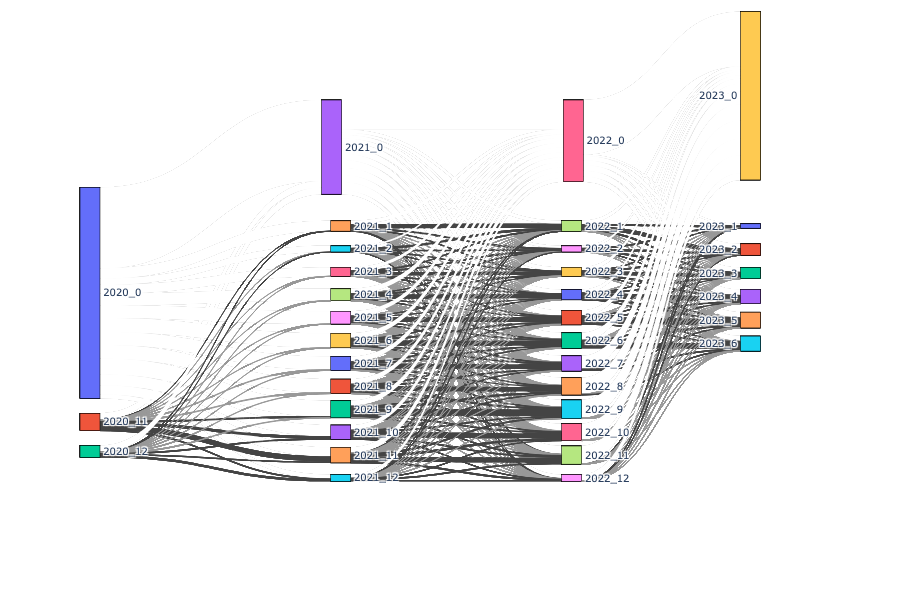

In [191]:
def define_color(x, y):
    month_target = int(x.split("_")[1])
    month_source = int(y.split("_")[1])
    if month_target == 0 or month_source == 0:
        return "#FFFFFF", 0.
    
    if (abs(month_target - month_source) < 3) or (abs(month_target - month_source) > 9):
        return "#444444", 0.8
    
    return "#999999", 0.8


l_targets = np.array(sankey_obj.node["label"])[ np.array(sankey_obj.link["target"], dtype=np.int) ]
l_sources = np.array(sankey_obj.node["label"])[ np.array(sankey_obj.link["source"], dtype=np.int) ]
l_colors = [ define_color(x, y)[0] for x,y in zip(l_targets, l_sources) ]
l_opacity = [ define_color(x, y)[1] for x,y in zip(l_targets, l_sources) ]


sankey_obj, sankey_dict = plt_sankey.plot_sankey(df_cnt, l_pairs, l_nodes=range(13))

nn = sankey_obj.node
nn["x"] = [0.1, 0., 0., 0.05] + [0.35 for x in range(12)] + [0.66 for x in range(13)] + [0.9 for x in range(7)]
nn["y"] = [0, 1.0, 1.1] +\
    [0] + list(np.linspace(0.3, 0.9, 12)) +\
    [0] + list(np.linspace(0.3, 0.9, 12)) +\
    [-0.01] + list(np.linspace(0.3, 0.58, 6))
sankey_obj.node = nn


ll = sankey_obj.link
sankey_obj.link["color"] = l_colors
sankey_obj.link["customdata"] = l_opacity

sankey_obj.arrangement = "fixed"
data.append(sankey_obj)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    autosize=False,
    width=1000, height=600,
    margin=dict(
        pad=1
    ),
)
fig.show()